In [27]:
import pandas as pd
import xmltodict
import zipfile
import numpy as np

In [13]:
import zipfile
import pandas as pd
import xmltodict

def new_data_parsing(zip_path:str = 'export.zip' ,save_csv_path:str = 'health_data.csv', save:bool = True) -> pd.DataFrame:
    """
    This function performs the following steps in an Apple Health export
    Unzip, parse xml and save as a csv file

    :param zip_path: the path to your export zip file
    :param save_csv_path: the path to save your csv. Must end in .csv
    :param save: Bool to determine if you wish to save the csv or just return it
    :return: Returns a data frame containing the parsed health data
    """

    ## Extracting zip
    with zipfile.ZipFile(zip_path,"r") as zip_ref:
        zip_ref.extractall()

    ## Parsing xml
    input_path = 'apple_health_export/export.xml'
    with open(input_path, 'r') as xml_file:
        input_data = xmltodict.parse(xml_file.read())

    ## Selecting only relevant dict keys
    records_list = input_data['HealthData']['Record']

    ## Creating and saving csv
    df = pd.DataFrame(records_list)
    if save:
        df.to_csv(save_csv_path,index=False, sep=';')

    return df

In [14]:
df.head()

,@type,@sourceName,@sourceVersion,@unit,@creationDate,@startDate,@endDate,@value,MetadataEntry,@device,HeartRateVariabilityMetadataList
0,HKQuantityTypeIdentifierDietaryWater,Lifesum,2,mL,2020-12-05 02:07:11 -0300,2020-12-05 02:07:11 -0300,2020-12-05 02:07:11 -0300,0,"[{'@key': 'HKMetadataKeySyncVersion', '@value'...",NaN,NaN
1,HKQuantityTypeIdentifierDietaryWater,Lifesum,3,mL,2020-06-16 16:07:10 -0300,2020-06-16 16:07:09 -0300,2020-06-16 16:07:09 -0300,0,"[{'@key': 'HKMetadataKeySyncVersion', '@value'...",NaN,NaN
2,HKQuantityTypeIdentifierDietaryWater,Lifesum,1,mL,2020-06-17 15:55:43 -0300,2020-06-17 15:55:42 -0300,2020-06-17 15:55:42 -0300,0,"[{'@key': 'HKMetadataKeySyncVersion', '@value'...",NaN,NaN
3,HKQuantityTypeIdentifierDietaryWater,Lifesum,1,mL,2020-06-19 20:02:19 -0300,2020-06-19 20:02:19 -0300,2020-06-19 20:02:19 -0300,0,"[{'@key': 'HKMetadataKeySyncVersion', '@value'...",NaN,NaN
4,HKQuantityTypeIdentifierDietaryWater,Lifesum,1,mL,2020-06-27 15:30:24 -0300,2020-06-27 15:30:24 -0300,2020-06-27 15:30:24 -0300,0,"[{'@key': 'HKMetadataKeySyncVersion', '@value'...",NaN,NaN


In [8]:
df['@type'].value_counts()

HKQuantityTypeIdentifierActiveEnergyBurned                1430914
HKQuantityTypeIdentifierHeartRate                          343706
HKQuantityTypeIdentifierBasalEnergyBurned                  320805
HKQuantityTypeIdentifierDistanceWalkingRunning             274731
HKQuantityTypeIdentifierStepCount                          262952
HKQuantityTypeIdentifierAppleExerciseTime                   46910
HKQuantityTypeIdentifierAppleStandTime                      37852
HKCategoryTypeIdentifierAppleStandHour                      26889
HKQuantityTypeIdentifierEnvironmentalAudioExposure          22457
HKQuantityTypeIdentifierWalkingSpeed                         8961
HKQuantityTypeIdentifierWalkingStepLength                    8949
HKQuantityTypeIdentifierFlightsClimbed                       8477
HKQuantityTypeIdentifierWalkingDoubleSupportPercentage       6846
HKQuantityTypeIdentifierHeadphoneAudioExposure               4313
HKCategoryTypeIdentifierSleepAnalysis                        3897
HKQuantity

In [9]:
df['@sourceName'].value_counts()

AppleÂ Watch de Gabriel        2233261
Gabrielâ€™s AppleÂ Watch        425216
iPhone de Gabriel Cassimiro     159725
AutoSleep                         1368
Lifesum                           1347
Forest                             158
Clock                              146
Renpho                             124
Headspace                           33
Health                               4
Name: @sourceName, dtype: int64

In [15]:
energy = df[df['@type'] == 'HKQuantityTypeIdentifierActiveEnergyBurned']

In [17]:
energy['@sourceName'].value_counts()


AppleÂ Watch de Gabriel     1237975
Gabrielâ€™s AppleÂ Watch     192939
Name: @sourceName, dtype: int64

In [18]:
%%time
format = '%Y-%m-%d %H:%M:%S %z'

energy['@creationDate'] = pd.to_datetime(energy['@creationDate'],
                                     format=format)
energy['@startDate'] = pd.to_datetime(energy['@startDate'],
                                  format=format)
energy['@endDate'] = pd.to_datetime(energy['@endDate'],
                                format=format)
energy['@value'] =energy['@value'].astype('float')

<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: total: 1min 37s
Wall time: 1min 58s


<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
energy

,@type,@sourceName,@sourceVersion,@unit,@creationDate,@startDate,@endDate,@value,MetadataEntry,@device,HeartRateVariabilityMetadataList
1202640,HKQuantityTypeIdentifierActiveEnergyBurned,AppleÂ Watch de Gabriel,8.1,Cal,2022-01-27 20:58:07-03:00,2022-01-27 20:55:40-03:00,2022-01-27 20:56:41-03:00,0.538,NaN,"<<HKDevice: 0x280668500>, name:Apple Watch, ma...",NaN
1202641,HKQuantityTypeIdentifierActiveEnergyBurned,AppleÂ Watch de Gabriel,8.1,Cal,2022-01-27 20:58:08-03:00,2022-01-27 20:56:41-03:00,2022-01-27 20:57:43-03:00,0.508,NaN,"<<HKDevice: 0x280668500>, name:Apple Watch, ma...",NaN
1202642,HKQuantityTypeIdentifierActiveEnergyBurned,AppleÂ Watch de Gabriel,8.1,Cal,2022-01-27 20:59:44-03:00,2022-01-27 20:57:43-03:00,2022-01-27 20:58:34-03:00,0.263,NaN,"<<HKDevice: 0x280668500>, name:Apple Watch, ma...",NaN
1202643,HKQuantityTypeIdentifierActiveEnergyBurned,AppleÂ Watch de Gabriel,8.1,Cal,2022-01-27 21:01:56-03:00,2022-01-27 20:58:34-03:00,2022-01-27 20:59:35-03:00,0.553,NaN,"<<HKDevice: 0x280668500>, name:Apple Watch, ma...",NaN
1202644,HKQuantityTypeIdentifierActiveEnergyBurned,AppleÂ Watch de Gabriel,8.1,Cal,2022-01-27 21:02:10-03:00,2022-01-27 20:59:35-03:00,2022-01-27 21:00:36-03:00,0.311,NaN,"<<HKDevice: 0x280668500>, name:Apple Watch, ma...",NaN
...,...,...,...,...,...,...,...,...,...,...,...
2633549,HKQuantityTypeIdentifierActiveEnergyBurned,Gabrielâ€™s AppleÂ Watch,8.6,Cal,2022-06-27 14:53:29-03:00,2022-06-27 14:52:20-03:00,2022-06-27 14:53:11-03:00,0.201,NaN,"<<HKDevice: 0x280668dc0>, name:Apple Watch, ma...",NaN
2633550,HKQuantityTypeIdentifierActiveEnergyBurned,Gabrielâ€™s AppleÂ Watch,8.6,Cal,2022-06-27 14:53:34-03:00,2022-06-27 14:53:11-03:00,2022-06-27 14:53:22-03:00,0.062,NaN,"<<HKDevice: 0x280668dc0>, name:Apple Watch, ma...",NaN
2633551,HKQuantityTypeIdentifierActiveEnergyBurned,Gabrielâ€™s AppleÂ Watch,8.6,Cal,2022-06-27 14:54:42-03:00,2022-06-27 14:53:22-03:00,2022-06-27 14:54:02-03:00,0.139,NaN,"<<HKDevice: 0x280668dc0>, name:Apple Watch, ma...",NaN
2633552,HKQuantityTypeIdentifierActiveEnergyBurned,Gabrielâ€™s AppleÂ Watch,8.6,Cal,2022-06-27 14:54:47-03:00,2022-06-27 14:54:02-03:00,2022-06-27 14:54:33-03:00,0.14,NaN,"<<HKDevice: 0x280668dc0>, name:Apple Watch, ma...",NaN


In [32]:
energy['date'] = energy['@startDate'].dt.strftime('%Y-%m-%d')

C:\Users\gabrielcassimiro\AppData\Local\Temp\ipykernel_5224\2212404062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy['date'] = energy['@startDate'].dt.strftime('%Y-%m-%d')


In [33]:
print(energy['date'].max(), energy['date'].min())

2022-06-27 2017-09-24


In [42]:
data = energy.groupby(['date'])['@value'].sum().reset_index()
data

,date,@value
0,2017-09-24,47.295
1,2017-09-25,573.783
2,2017-09-26,651.558
3,2017-09-27,586.813
4,2017-09-28,352.367
...,...,...
1629,2022-06-23,1065.173
1630,2022-06-24,1006.606
1631,2022-06-25,512.258
1632,2022-06-26,713.598


In [43]:
data['@value'].max()

1132.418

In [44]:
data['@value'].describe()

count    1634.000000
mean      445.899458
std       207.319226
min         0.009000
25%       322.892250
50%       410.203500
75%       549.594250
max      1132.418000
Name: @value, dtype: float64

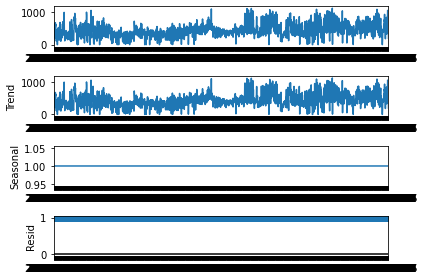

In [46]:
import statsmodels.api as sm
df = data.copy()
df = df.sort_values('date').set_index('date')


decomposition = sm.tsa.seasonal_decompose(df, model='multiplicative', period=1)
decomposition.plot();

In [ ]:
x

In [ ]:
def data_preprocessing():
    energy = df[df['@type'] == 'HKQuantityTypeIdentifierActiveEnergyBurned']

    format = '%Y-%m-%d %H:%M:%S %z'

    energy['@creationDate'] = pd.to_datetime(energy['@creationDate'],
                                             format=format)
    energy['@startDate'] = pd.to_datetime(energy['@startDate'],
                                          format=format)
    energy['@endDate'] = pd.to_datetime(energy['@endDate'],
                                        format=format)
    energy['@value'] =energy['@value'].astype('float')

    energy['date'] = energy['@startDate'].dt.strftime('%Y-%m-%d')

    data = energy.groupby(['date'])['@value'].sum().reset_index()
